In [1]:
import os

import numpy as np
import cv2
import uuid
import time
import pandas as pd

import xmltodict
import glob
import xml.etree.ElementTree as ET
import random as rnd
import splitfolders
import easyocr
import PIL
import copy

from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import Counter
from PIL import Image
from tqdm.auto import tqdm
from GPUtil import showUtilization as gpu_usage
from numba import cuda
from timeit import default_timer as timer

import torch

import matplotlib
matplotlib.use('TkAgg')

from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from matplotlib import patches as mpatches

In [ ]:
Подготовка данных

In [2]:
dataset = {
            "file":[],
            "width":[],
            "height":[],
            "xmin":[],
            "ymin":[],
            "xmax":[],
            "ymax":[]
           }

In [3]:
img_names=[] 
annotations=[]
for dirname, _, filenames in os.walk("plate"):
    for filename in filenames:
        if os.path.join(dirname, filename)[-3:]==("png" or "jpg"):
            img_names.append(filename)
        elif os.path.join(dirname, filename)[-3:]=="xml":
            annotations.append(filename)

In [4]:
img_names[:10]

['Cars0.png',
 'Cars1.png',
 'Cars10.png',
 'Cars100.png',
 'Cars101.png',
 'Cars102.png',
 'Cars103.png',
 'Cars104.png',
 'Cars105.png',
 'Cars106.png']

In [5]:
annotations[:10]

['misc.xml',
 'modules.xml',
 'workspace.xml',
 'profiles_settings.xml',
 'Cars0.xml',
 'Cars1.xml',
 'Cars10.xml',
 'Cars100.xml',
 'Cars101.xml',
 'Cars102.xml']

In [6]:
path_annotations="plate/annotations/*.xml" 

for item in glob.glob(path_annotations):
    tree = ET.parse(item)
    
    for elem in tree.iter():
        if 'filename' in elem.tag:
            filename=elem.text
        elif 'width' in elem.tag:
            width=int(elem.text)
        elif 'height' in elem.tag:
            height=int(elem.text)
        elif 'xmin' in elem.tag:
            xmin=int(elem.text)
        elif 'ymin' in elem.tag:
            ymin=int(elem.text)
        elif 'xmax' in elem.tag:
            xmax=int(elem.text)
        elif 'ymax' in elem.tag:
            ymax=int(elem.text)
            
            dataset['file'].append(filename)
            dataset['width'].append(width)
            dataset['height'].append(height)
            dataset['xmin'].append(xmin)
            dataset['ymin'].append(ymin)
            dataset['xmax'].append(xmax)
            dataset['ymax'].append(ymax)
        
classes = ['license']

In [7]:
df=pd.DataFrame(dataset)
df

,file,width,height,xmin,ymin,xmax,ymax
0,Cars0.png,500,268,226,125,419,173
1,Cars1.png,400,248,134,128,262,160
2,Cars10.png,400,225,140,5,303,148
3,Cars100.png,400,267,175,114,214,131
4,Cars101.png,400,300,167,202,240,220
...,...,...,...,...,...,...,...
466,Cars95.png,600,400,278,182,407,263
467,Cars96.png,400,248,133,126,261,160
468,Cars97.png,400,300,98,102,297,191
469,Cars98.png,370,400,85,196,247,259


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    471 non-null    object
 1   width   471 non-null    int64 
 2   height  471 non-null    int64 
 3   xmin    471 non-null    int64 
 4   ymin    471 non-null    int64 
 5   xmax    471 non-null    int64 
 6   ymax    471 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 25.9+ KB


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


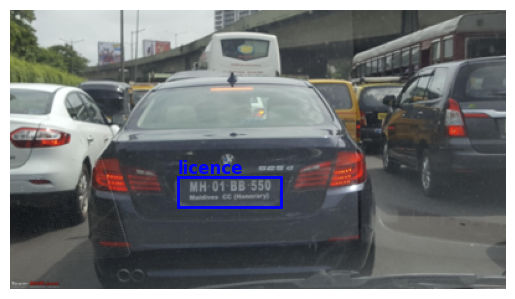

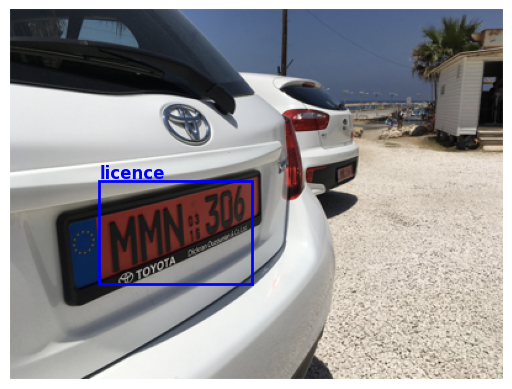

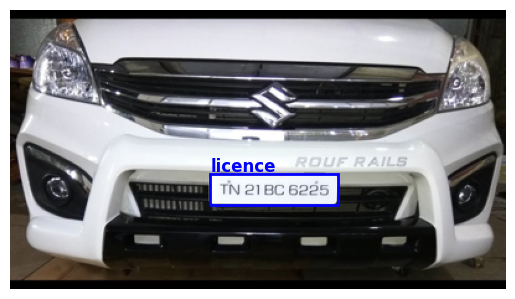

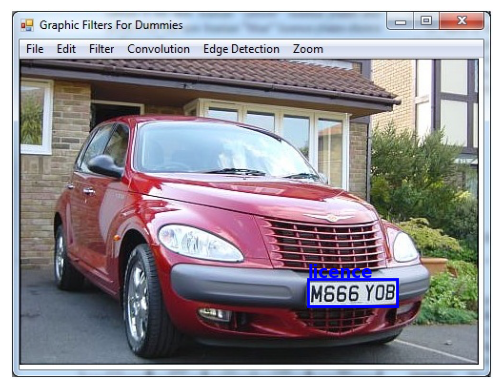

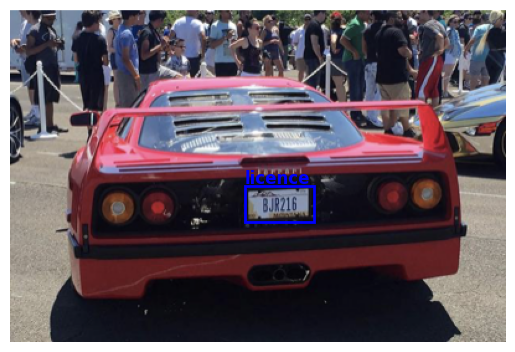

In [11]:
%pylab inline

def print_random_images(photos: list, n: int = 5, seed=None) -> None:
    if n > 10:
        n=10
    
    if seed:
        rnd.seed(seed)
        
    random_photos = rnd.sample(photos, n)
    
    for image_path in random_photos:
        
        with Image.open(image_path) as fd:
            fig, ax = plt.subplots()
            ax.imshow(fd)           
            ax.axis(False)
            
            for i, file in enumerate(df.file):
                if file in image_path:
                    x1,y1,x2,y2=list(df.iloc[i, -4:])
                        
                    mpatch=mpatches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1, edgecolor='b',facecolor="none",lw=2,)                    
                    ax.add_patch(mpatch)
                    rx, ry = mpatch.get_xy()
                    ax.annotate('licence', (rx, ry-2), color='blue', weight='bold', fontsize=12, ha='left', va='baseline')
                    
photos_path = "plate/images/*.png"
photos_list = glob.glob(photos_path)

print_random_images(photos_list)

In [12]:
x_pos = []
y_pos = []
frame_width = []
frame_height = []

labels_path = Path("plate/labels")

labels_path.mkdir(parents=True, exist_ok=True)

save_type = 'w'

for i, row in enumerate(df.iloc):
    current_filename = str(row.file[:-4])
    
    width, height, xmin, ymin, xmax, ymax = list(df.iloc[i][-6:])
    
    x=(xmin+xmax)/2/width
    y=(ymin+ymax)/2/height
    width=(xmax-xmin)/width
    height=(ymax-ymin)/height
    
    x_pos.append(x)
    y_pos.append(y)
    frame_width.append(width)
    frame_height.append(height)
    
    txt = '0' + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + '\n'
    
    if i > 0:
        previous_filename = str(df.file[i-1][:-4])
        save_type='a+' if current_filename == previous_filename else 'w'
    
    
    with open("plate/labels/" + str(row.file[:-4]) +'.txt', save_type) as f:
        f.write(txt)
        
        
df['x_pos']=x_pos
df['y_pos']=y_pos
df['frame_width']=frame_width
df['frame_height']=frame_height

df

,file,width,height,xmin,ymin,xmax,ymax,x_pos,y_pos,frame_width,frame_height
0,Cars0.png,500,268,226,125,419,173,0.645000,0.555970,0.386000,0.179104
1,Cars1.png,400,248,134,128,262,160,0.495000,0.580645,0.320000,0.129032
2,Cars10.png,400,225,140,5,303,148,0.553750,0.340000,0.407500,0.635556
3,Cars100.png,400,267,175,114,214,131,0.486250,0.458801,0.097500,0.063670
4,Cars101.png,400,300,167,202,240,220,0.508750,0.703333,0.182500,0.060000
...,...,...,...,...,...,...,...,...,...,...,...
466,Cars95.png,600,400,278,182,407,263,0.570833,0.556250,0.215000,0.202500
467,Cars96.png,400,248,133,126,261,160,0.492500,0.576613,0.320000,0.137097
468,Cars97.png,400,300,98,102,297,191,0.493750,0.488333,0.497500,0.296667
469,Cars98.png,370,400,85,196,247,259,0.448649,0.568750,0.437838,0.157500


In [13]:
input_folder = Path("plate")
output_folder = Path("yolov5/data/Plate_recognition")
splitfolders.ratio(
    input_folder,
    output=output_folder,
    seed=42,
    ratio=(0.8, 0.2),
    group_prefix=None
)
print("Moving files finished.")

Copying files: 1317 files [00:01, 732.47 files/s] 

Moving files finished.


In [14]:
def walk_through_dir(dir_path: Path) -> None:
    """Prints dir_path content"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directiories and {len(filenames)} files in '{dirpath}' folder ")

    
walk_through_dir(input_folder)
print()
walk_through_dir(output_folder)

There are 7 directiories and 1 files in 'plate' folder 
There are 1 directiories and 5 files in 'plate\.idea' folder 
There are 0 directiories and 1 files in 'plate\.idea\inspectionProfiles' folder 
There are 0 directiories and 433 files in 'plate\annotations' folder 
There are 0 directiories and 433 files in 'plate\images' folder 
There are 0 directiories and 433 files in 'plate\labels' folder 
There are 6 directiories and 0 files in 'plate\train' folder 
There are 0 directiories and 346 files in 'plate\train\annotations' folder 
There are 0 directiories and 346 files in 'plate\train\images' folder 
There are 0 directiories and 346 files in 'plate\train\labels' folder 
There are 0 directiories and 0 files in 'plate\train\train' folder 
There are 0 directiories and 0 files in 'plate\train\val' folder 
There are 0 directiories and 11 files in 'plate\train\yolov5-master' folder 
There are 6 directiories and 0 files in 'plate\val' folder 
There are 0 directiories and 87 files in 'plate\va

In [15]:
import yaml

yaml_file = 'yolov5/data/plates.yaml'

yaml_data = dict(
    path = "data/Plate_recognition",
    train = "train",
    val = "val",
    nc = len(classes),
    names = classes
)

with open(yaml_file, 'w') as f:
    yaml.dump(yaml_data, f, explicit_start = True, default_flow_style = False)

In [16]:
device = '0' if torch.cuda.is_available() else 'cpu' 
device

'cpu'

In [17]:
start_time = timer()

!cd yolov5 && python train.py --workers 2 --img 640 --batch 16 --epochs 100 --data "data/plates.yaml" --weights yolov5s.pt --device {device} --cache

end_time = timer()

print(f'Training time: {(end_time-start_time):.2f}')

Training time: 0.17


python: can't open file 'train.py': [Errno 2] No such file or directory


In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path = 'yolov5/runs/train/exp77/weights/best.pt', force_reload=True)

reader = easyocr.Reader(['en'])

In [18]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', force_reload=True)

reader = easyocr.Reader(['en'])

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\Adel/.cache\torch\hub\master.zip
YOLOv5  2023-6-16 Python-3.11.1 torch-2.0.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [19]:
def get_plates_xy(frame: np.ndarray, labels: list, row: list, width: int, height: int, reader: easyocr.Reader) -> tuple:
    '''Get the results from easyOCR for each frame and return them with bounding box coordinates'''
    
    x1, y1, x2, y2 = int(row[0]*width), int(row[1]*height), int(row[2]*width), int(row[3]*height) ## BBOx coordniates
    plate_crop = frame[int(y1):int(y2), int(x1):int(x2)]
    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2) ## BBox
    ocr_result = reader.readtext(np.asarray(plate_crop), allowlist = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')#, paragraph="True", min_size=50)
    
    return ocr_result, x1, y1


def detect_text(i: int, row: list, x1: int, y1: int, ocr_result: list, detections: list, yolo_detection_prob: float=0.3) -> list:
    '''Checks the detection's probability, discards those with low prob and rewrites output from ocr_reader to >>detections<< list'''
    
    if row[4] >= yolo_detection_prob: #discard predictions below the value             
        if(len(ocr_result))>0:
            for item in ocr_result:     
                    detections[i][0]=item[1]
                    detections[i][1]=[x1, y1]
                    detections[i][2]=item[2]
                    
    return detections


def is_adjacent(coord1: list, coord2: list) -> bool:
    '''Checks if [x, y] from list coord1 is similar to coord2'''
    
    MAX_PIXELS_DIFF=50
    
    if (abs(coord1[0] - coord2[0]) <= MAX_PIXELS_DIFF) and (abs(coord1[1] - coord2[1]) <= MAX_PIXELS_DIFF):
        return True
    else:
        return False
    

def sort_detections(detections: list, plates_data: list) -> list:
    '''Looks at detections from last frame and rewrites indexes for similar coordinates'''
    
    for m in range(0, len(detections)):
        for n in range(0, len(plates_data)):
            if not detections[m][1]==[0, 0] and not plates_data[n][1]==[0,0]:
                if is_adjacent(detections[m][1], plates_data[n][1]):
                    if m!=n:
                        temp=detections[m]
                        detections[m]=detections[n]
                        detections[n]=temp
                        
    return detections


def delete_old_labels(detections: list, count_empty_labels: list, plates_data: list, frames_to_reset: int=3) -> tuple:
    '''If earlier detected plate isn't spotted for the next >>FRAMES_TO_RESET<< frames, delete it from >>plates_data<<'''
    
    for m in range(0, len(detections)):
        if detections[m][0]=='None' and not count_empty_labels[m]==frames_to_reset:
            count_empty_labels[m]+=1
        elif count_empty_labels[m]==frames_to_reset:
            count_empty_labels[m]=0
            plates_data[m]=['None', [0,0], 0]
        else:
            count_empty_labels[m]=0
            
    return plates_data, count_empty_labels


def overwrite_plates_data(detections: list, plates_data: list, plate_lenght=None) -> list:
    '''Checks coordinates from >>detections<<, if there is similar record in >>plate_data<< tries to overwrite it (only if probability is higher)'''
    
    if (detections[i][2]>plates_data[i][2] or detections[i][2]==0):
        if plate_lenght:
            if len(detections[i][0])==plate_lenght:
                plates_data[i][0]=detections[i][0]
                plates_data[i][2]=detections[i][2]       
        else:
            plates_data[i][0]=detections[i][0]
            plates_data[i][2]=detections[i][2]
    plates_data[i][1]=detections[i][1]
        
    return plates_data

Photo width,height: 1024,683. Detected plates: 1
Detection: 1. YOLOv5 prob: 0.64, easyOCR results: [[[[242, 342], [478, 342], [478, 398], [242, 398]], 'B9O4KA76Z']]


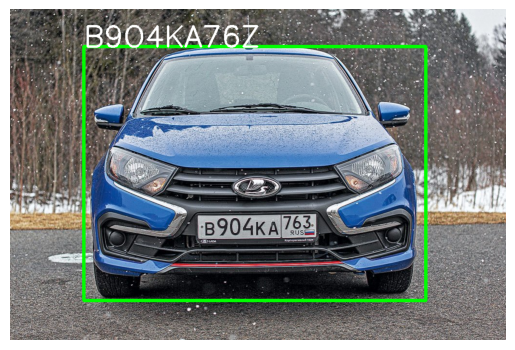

In [20]:
%matplotlib inline

test_photo_path = "2.jpeg"

results = model(test_photo_path)
detections=np.squeeze(results.render())

labels, coordinates = results.xyxyn[0][:, -1], results.xyxyn[0][:, :-1]
image = cv2.imread(test_photo_path)
width, height = image.shape[1], image.shape[0]

print(f'Photo width,height: {width},{height}. Detected plates: {len(labels)}')

for i in range(len(labels)):
    row = coordinates[i]
    if row[4] >= 0.6:
        x1, y1, x2, y2 = int(row[0]*width), int(row[1]*height), int(row[2]*width), int(row[3]*height)
        plate_crop = image[int(y1):int(y2), int(x1):int(x2)]
        ocr_result = reader.readtext((plate_crop), paragraph="True", min_size=120, allowlist = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
        text=ocr_result[0][1]
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 6) ## BBox
        cv2.putText(image, f"{text}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 3)
        plt.axis(False)
        plt.imshow((image)[...,::-1])
        
        print(f'Detection: {i+1}. YOLOv5 prob: {row[4]:.2f}, easyOCR results: {ocr_result}')

Photo width,height: 1000,667. Detected plates: 2
Detection: 1. YOLOv5 prob: 0.80, easyOCR results: [[[[211, 464], [472, 464], [472, 521], [211, 521]], 'A302HE76']]


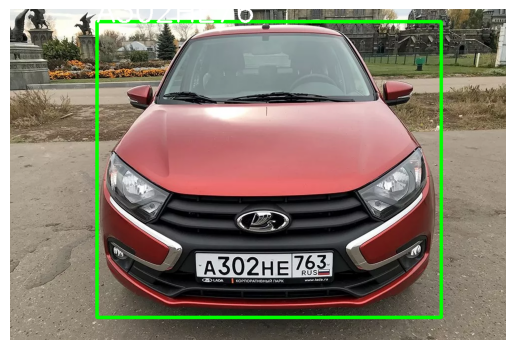

In [23]:
%matplotlib inline

test_photo_path = "31.jpg"

results = model(test_photo_path)
detections=np.squeeze(results.render())

labels, coordinates = results.xyxyn[0][:, -1], results.xyxyn[0][:, :-1]
image = cv2.imread(test_photo_path)
width, height = image.shape[1], image.shape[0]

print(f'Photo width,height: {width},{height}. Detected plates: {len(labels)}')

for i in range(len(labels)):
    row = coordinates[i]
    if row[4] >= 0.7:
        x1, y1, x2, y2 = int(row[0]*width), int(row[1]*height), int(row[2]*width), int(row[3]*height)
        plate_crop = image[int(y1):int(y2), int(x1):int(x2)]
        ocr_result = reader.readtext((plate_crop), paragraph="True", min_size=120, allowlist = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
        text=ocr_result[0][1]
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 6) ## BBox
        cv2.putText(image, f"{text}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 3)
        plt.axis(False)
        plt.imshow((image)[...,::-1])
        
        print(f'Detection: {i+1}. YOLOv5 prob: {row[4]:.2f}, easyOCR results: {ocr_result}')

In [24]:
text

'A302HE76'